In [1]:
# Internal modules
import os
import joblib
from pathlib import Path

# External modules
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# User modules
import src.utils.constantes as cst
import src.utils.summary as summary
import src.utils.auxiliary as auxiliary
from src.processing import dataloader
from src.processing import filtering
import src.models.scorer as scorer
import src.models.models as models
import src.models.display_results as display

%load_ext autoreload
%autoreload 2
# Paths
BASE_DIR = Path("./")
OUTPUT_DIR = BASE_DIR / "results/"
DATA_DIR = BASE_DIR / "data/"
#
results = Path("results/timepoint/")
results.mkdir(parents=True, exist_ok=True)

### Dataset options

In [3]:
# Conditions
FILTER_COLUMNS = {
    "Condition": "WT",
    "Type": "CD3",
    "Mask": 1,
    "Density20": True
}
# Filter dataset
REMOVE_NONE = True
REPLACE_ABERRANT = -1

# Sample, feature, target columns
SAMPLE = ["FileName"]
REMOVE_SAMPLE = None
FEATURES = {"fiber-dist-shape": cst.x_fiber_columns}
TARGETS = [dataloader.enrich_2_cmask]
TARGETS_COLNAMES = [target_col(return_key=True) for target_col in TARGETS]

### Model options

In [4]:
SCORING = {
    **scorer.accuracy_score(wrap_scorer=True),
    **scorer.balanced_accuracy_score(wrap_scorer=True),
    **scorer.precision_score(wrap_scorer=True),
    **scorer.recall_score(wrap_scorer=True),
    **scorer.roc_auc_score(wrap_scorer=True),
    **scorer.matthews_corrcoef(wrap_scorer=True),
    **scorer.f1_score(wrap_scorer=True),
}
SCORING_base = {
    **scorer.accuracy_score(wrap_scorer=False),
    **scorer.balanced_accuracy_score(wrap_scorer=False),
    **scorer.precision_score(wrap_scorer=False),
    **scorer.recall_score(wrap_scorer=False),
    **scorer.roc_auc_score(wrap_scorer=False),
    **scorer.matthews_corrcoef(wrap_scorer=False),
    **scorer.f1_score(wrap_scorer=False),
}

# Generic attributes
SEED = 42
TEST_SIZE = 0.3

## Process
SAMPLE_GROUP = None if SAMPLE == [] else SAMPLE

In [5]:
filename = []
for key, val in FILTER_COLUMNS.items():
    if isinstance(val, list):
        val = [str(v) for v in val]
        val = str(key) + "=" + "-".join(val)
    elif isinstance(val, (int, bool)):
        val = str(key) + "=" + str(val)
    filename.append(val)
filename = "_".join(filename)
filename

'WT_CD3_Mask=1_Density20=True'

In [6]:
timepoint_dataset = "data/output.csv.gz"  # "data/WT_DAYS.csv"
dataset_days = dataloader.Loader(
    filepath=timepoint_dataset, sep=","
)
dataset_days.data

,TimeCondition,FileName,Condition,X,Y,Coherency100,Energy100,MeanInt100,VarInt100,Density100,...,Angle140,Mask,Type,Cells,Cells100um,CellArea,CellArea100um,CellEcc,CellEcc100um,Frac
0,D15,20251011_Zoe_D15_Tum1_20um_Romanecutlastone_ma...,WT,8386,27,0.000898,1.226000e-08,0.0,0.0,0.0,...,0.191970,0.0,CD3,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1,D15,20251011_Zoe_D15_Tum1_20um_Romanecutlastone_ma...,WT,8426,27,0.001000,1.802000e-08,0.0,0.0,0.0,...,0.191604,0.0,CD3,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2,D15,20251011_Zoe_D15_Tum1_20um_Romanecutlastone_ma...,WT,8466,27,0.002000,2.564000e-08,0.0,0.0,0.0,...,0.191237,0.0,CD3,NaN,0.0,NaN,NaN,NaN,NaN,NaN
3,D15,20251011_Zoe_D15_Tum1_20um_Romanecutlastone_ma...,WT,8506,27,0.003000,3.523000e-08,0.0,0.0,0.0,...,0.190871,0.0,CD3,NaN,0.0,NaN,NaN,NaN,NaN,NaN
4,D15,20251011_Zoe_D15_Tum1_20um_Romanecutlastone_ma...,WT,8546,27,0.004000,4.670000e-08,0.0,0.0,0.0,...,0.190504,0.0,CD3,NaN,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1961203,D8,MAX_20251027_Zoe_D8_Tum4_diffsettings_preproce...,WT,7465,17072,0.000080,1.890000e-06,NaN,NaN,NaN,...,1.062876,0.0,CD3,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1961204,D8,MAX_20251027_Zoe_D8_Tum4_diffsettings_preproce...,WT,7505,17072,0.000042,1.014000e-06,NaN,NaN,NaN,...,1.116510,0.0,CD3,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1961205,D8,MAX_20251027_Zoe_D8_Tum4_diffsettings_preproce...,WT,7545,17072,0.000022,5.383000e-07,NaN,NaN,NaN,...,1.163686,0.0,CD3,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1961206,D8,MAX_20251027_Zoe_D8_Tum4_diffsettings_preproce...,WT,7585,17072,0.000011,2.827000e-07,NaN,NaN,NaN,...,1.199570,0.0,CD3,NaN,0.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
dataset_days.data["TimeCondition"].value_counts()

TimeCondition
D15    620257
D17    515162
D8     417296
D12    408493
Name: count, dtype: int64

In [ ]:
filter_tumor = ["MAX_20251027_Zoe_D8_Tum4_diffsettings_preprocess_SHG-1.tif_rescaled.tif_data.pkl"]
dataset_days.data = dataset_days.data.loc[~dataset_days.data["FileName"].isin(filter_tumor), :]
dataset_days.data["TimeCondition"].value_counts()

TimeCondition
D15    620257
D17    515162
D12    408493
D8     328778
Name: count, dtype: int64

In [ ]:
# Replace aberrant values by a default one (places without fiber)
dataset_days.data.loc[dataset_days.data["Density20"] <= 0, cst.aberrant_columns] = REPLACE_ABERRANT
dataset_days.data = dataset_days.data.assign(**dataloader.enrich_2_cmask(dataset_days.data))
FILTER_COLUMNS = {
    "Condition": "WT",
    "Type": "CD3",
    "Mask": 1,
    "Density20": True
}
preprocess = filtering.Preprocess(
    rows_categories=FILTER_COLUMNS,
    rows_nonnan=True  # filter row containing nan
)
dataframe_days = preprocess(dataset_days.data)
dataframe_days.columns, dataframe_days["TimeCondition"].value_counts()

(Index(['TimeCondition', 'FileName', 'Condition', 'X', 'Y', 'Coherency100',
        'Energy100', 'MeanInt100', 'VarInt100', 'Density100', 'VarDensity100',
        'Coherency140', 'Energy140', 'MeanInt140', 'VarInt140', 'Density140',
        'VarDensity140', 'Coherency20', 'Energy20', 'MeanInt20', 'VarInt20',
        'Density20', 'VarDensity20', 'Coherency60', 'Energy60', 'MeanInt60',
        'VarInt60', 'Density60', 'VarDensity60', 'OrientationRef20',
        'OrientationRef60', 'OrientationRef100', 'OrientationRef140', 'Dist',
        'Angle20', 'Angle60', 'Angle100', 'Angle140', 'Mask', 'Type', 'Cells',
        'Cells100um', 'CellArea', 'CellArea100um', 'CellEcc', 'CellEcc100um',
        'Frac', 'enrich_2'],
       dtype='object'),
 TimeCondition
 D15    148916
 D17    109229
 D12     94044
 D8      73404
 Name: count, dtype: int64)

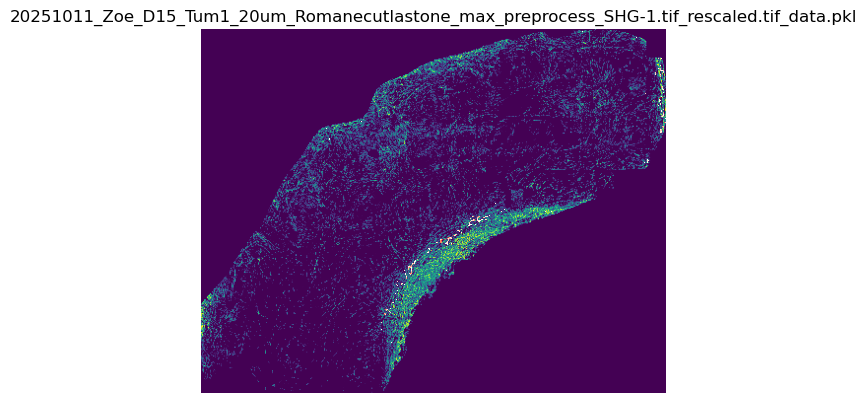

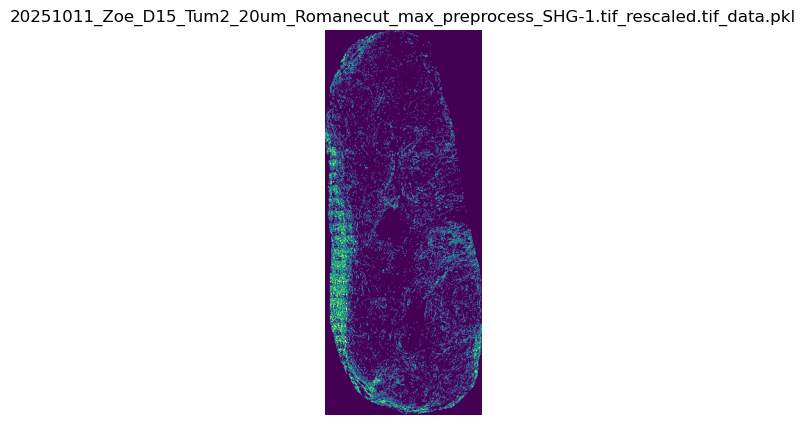

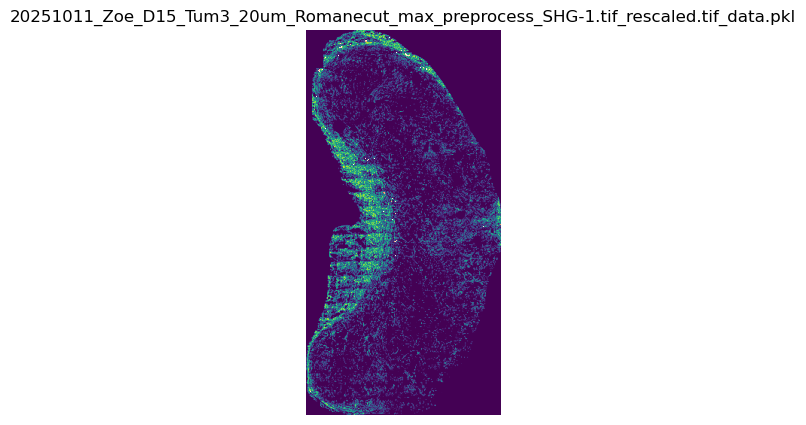

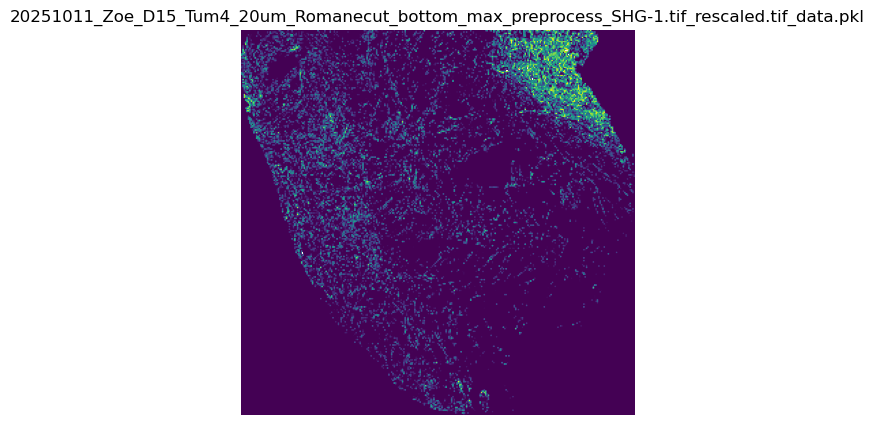

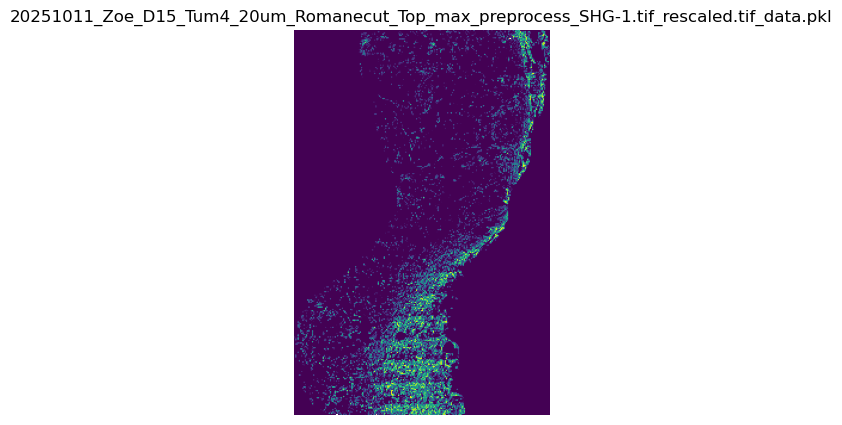

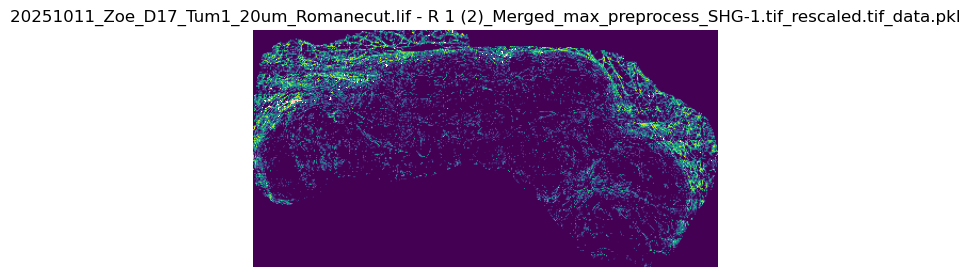

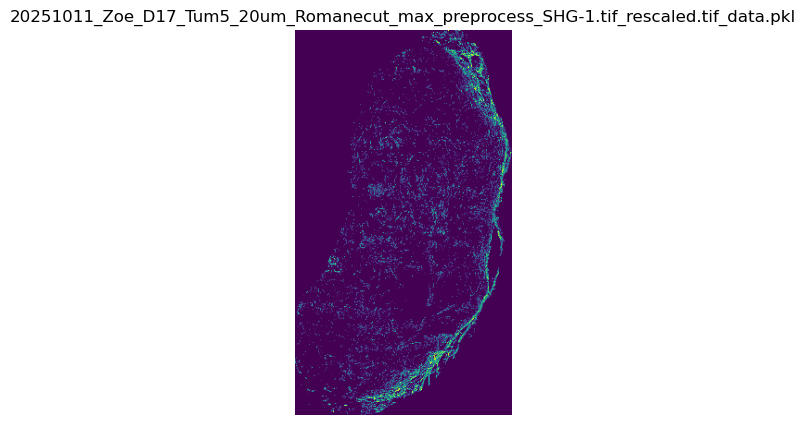

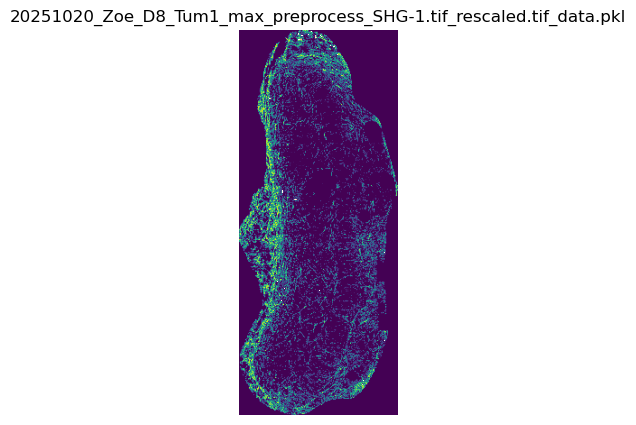

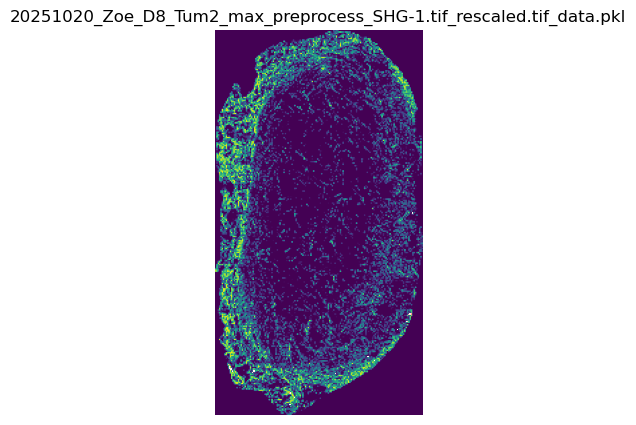

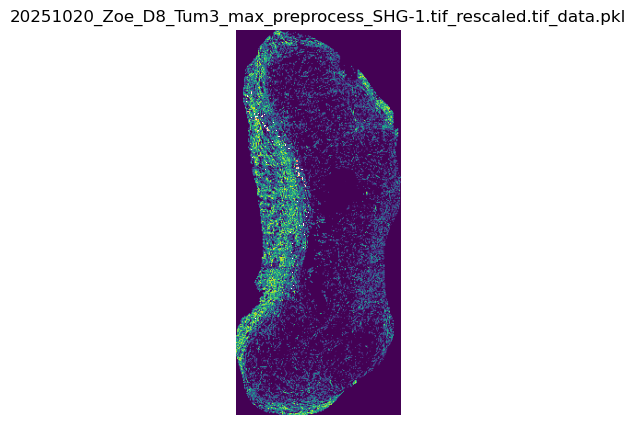

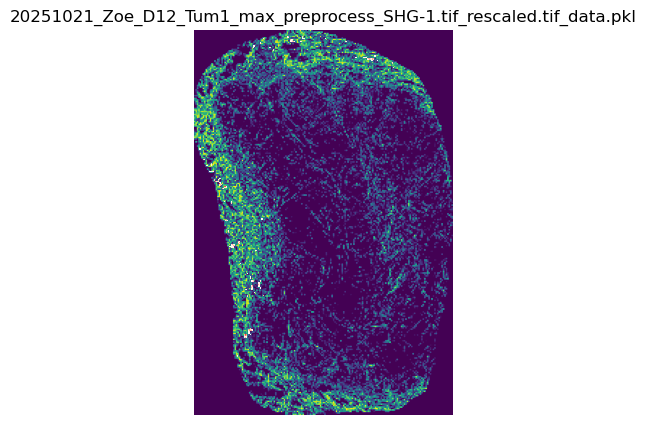

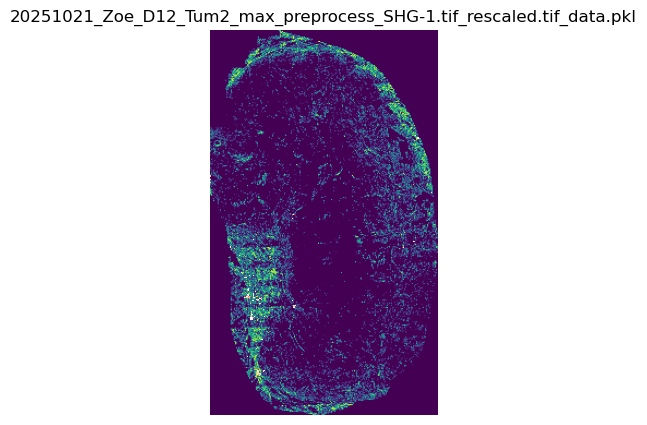

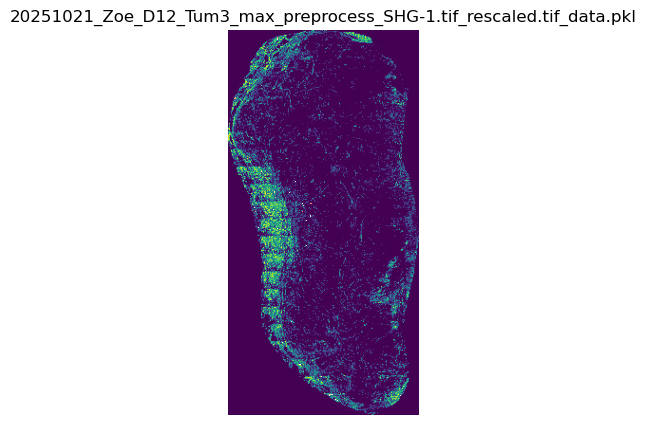

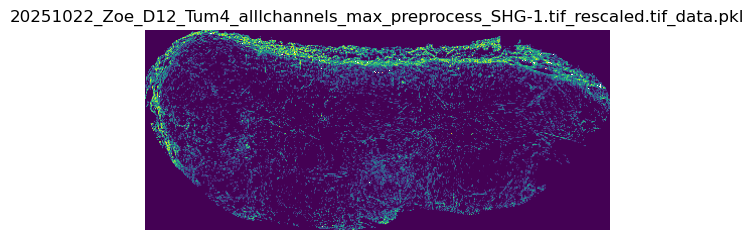

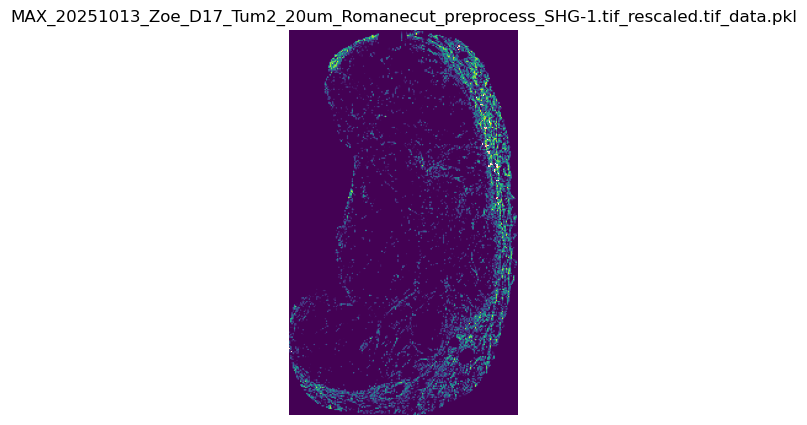

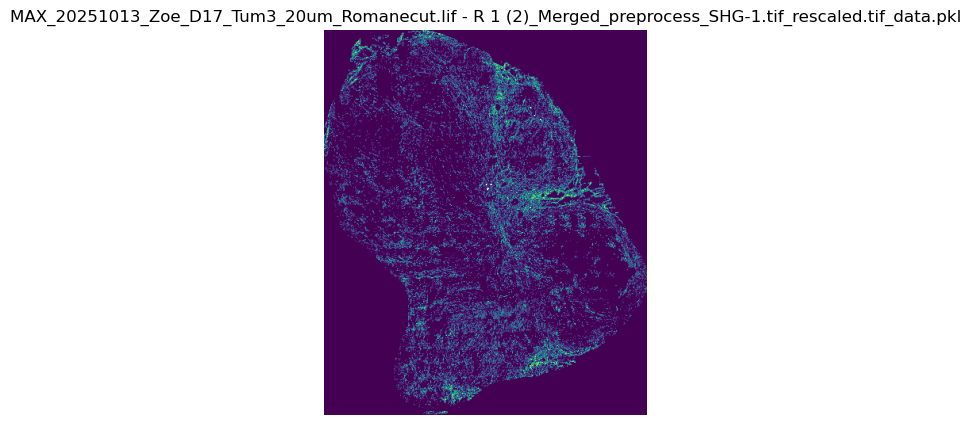

In [ ]:
from src.utils import extract
import matplotlib.pyplot as plt

for i in dataframe_days["FileName"].unique():
    m = extract.extract_map(
        dataframe_days,
        "Density20",
        sample_name=i
    )
    m2 = extract.extract_map(
        dataframe_days,
        "Cells",
        sample_name=i
    )
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.imshow(m, cmap='viridis')
    ax.imshow(np.ma.masked_where(m2 <= 0, m2), cmap=plt.cm.Reds)
    ax.axis("off")
    ax.set_title(i)
    plt.savefig(results / f"{i}.png")
    plt.show()

In [11]:
# Selected features and target
features_column = FEATURES["fiber-dist-shape"]
target_column = TARGETS_COLNAMES[0]
# Best parameters
estimator_param = {
    'n_estimators': 32,
    'min_samples_split': 8,
    'min_samples_leaf': 1,
    'max_features': 'sqrt',
    'max_depth': 10,
    'criterion': 'entropy',
    'class_weight': 'balanced',
    'bootstrap': True
}

Predicting on timepoint dataset using base dataset

TRAIN 70%:  {'accuracy': [0.7403084772502224], 'balanced_accuracy': [0.7480836350833937], 'precision': [0.3523038421904902], 'recall': [0.7594727822793915], 'auc': [0.7480836350833937], 'mcc': [0.382131311164674], 'f1': [0.48132902481865353]}
TEST 30%:  {'accuracy': [0.7325146070583812], 'balanced_accuracy': [0.7312272545271932], 'precision': [0.3400929932787036], 'recall': [0.729341494718136], 'auc': [0.7312272545271932], 'mcc': [0.3566163584864823], 'f1': [0.4638786851276255]}


(<Figure size 1000x900 with 2 Axes>,
 <Axes: xlabel='Predicted label', ylabel='True label'>)

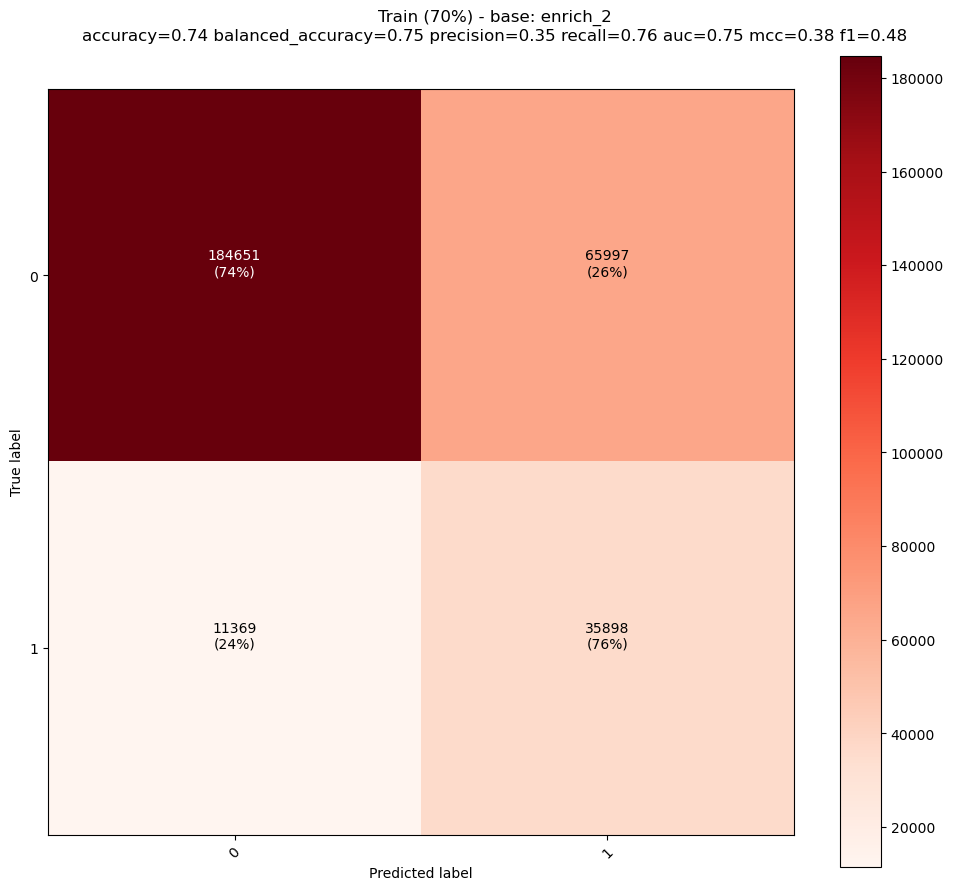

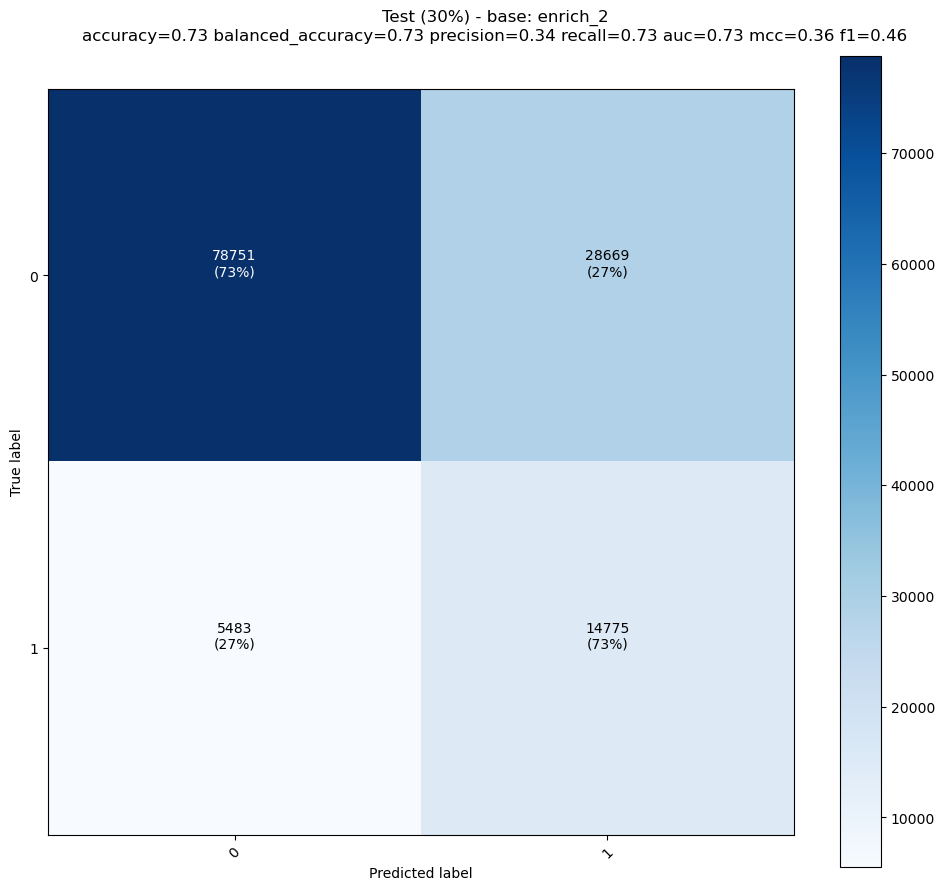

In [12]:
time_tt_dir = results / "alltime_on_alltime" / "train-test"
time_tt_dir.mkdir(parents=True, exist_ok=True)

from sklearn.model_selection import train_test_split
x_t, y_t, groups_t = models.split_xy(
    df=dataframe_days, x_columns=features_column, y_columns=target_column, groups=SAMPLE_GROUP
)
x_t_train, x_t_test, y_t_train, y_t_test = train_test_split(
    x_t, y_t, test_size=TEST_SIZE, random_state=SEED, stratify=dataframe_days["enrich_2"]
)
estimator_t = RandomForestClassifier(**estimator_param, random_state=SEED)
estimator_t.fit(x_t_train, y_t_train.ravel())
obs_train, pred_train = models.predict_model(x_t_train, y_t_train, estimator_t)
obs_test, pred_test = models.predict_model(x_t_test, y_t_test, estimator_t)
# Metrics
scores_t_train = models.scorer_model(
    estimator=estimator_t, x=x_t_train, y=y_t_train, scorer=SCORING_base
)
scores_t_test = models.scorer_model(
    estimator=estimator_t, x=x_t_test, y=y_t_test, scorer=SCORING_base
)
scores_t = pd.DataFrame(index=SCORING_base.keys())
scores_t["train"] = [v[0] for v in scores_t_train.values()]
scores_t["test"] = [v[0] for v in scores_t_test.values()]
score_t_train_print = " ".join([f"{k}={v[0]:.2f}" for k,v in scores_t_train.items()])
score_t_test_print = " ".join([f"{k}={v[0]:.2f}" for k,v in scores_t_test.items()])
print("TRAIN 70%: ", scores_t_train)
print("TEST 30%: ", scores_t_test)
scores_t.to_csv(time_tt_dir / f"alltimes_performances.csv")
display.display_confusion_matrix(
    observed=y_t_train, predicted=pred_train, cmap="Reds",
    labels=None, filepath=time_tt_dir / f"alltime_{1-TEST_SIZE}_confusion_matrix_on_train.png",
    title=f"Train (70%) - base: {target_column}\n{score_t_train_print}"
)
display.display_confusion_matrix(
    observed=y_t_test, predicted=pred_test, cmap="Blues",
    labels=None, filepath=time_tt_dir / f"alltime_{TEST_SIZE}_confusion_matrix_on_test.png",
    title=f"Test (30%) - base: {target_column}\n{score_t_test_print}"
)
    #